# 实战Kaggle 图像分类cifar-10

In [2]:
# import sys
# sys.path.append("../input/d2ld2l")
# import d2l

import collections
import math
import os
import shutil
import pandas as pd
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

## 1 获取并组织数据集

### 1.1 下载数据集

In [3]:
d2l.DATA_HUB['cifar10_tiny'] = (d2l.DATA_URL + 'kaggle_cifar10_tiny.zip',
                                '2068874e4b9a9f0fb07ebe0ad2b29754449ccacd')

# 如果使用完整的Kaggle竞赛的数据集，设置demo为False
demo = False

if demo:
    data_dir = d2l.download_extract('cifar10_tiny')
else:
    data_dir = '../data/cifar-10/'

### 1.2 整理数据集

我们需要整理数据集来训练和测试模型。 首先，我们用以下函数读取CSV文件中的标签，它返回一个字典，该字典将文件名中不带扩展名的部分映射到其标签。

In [4]:
def read_csv_labels(fname):
    """读取fname来给标签字典返回一个文件名"""
    with open(fname, 'r') as f:
        # 跳过文件头行(列名)
        lines = f.readlines()[1:]
    # str.rstrip([chars]) chars -- 指定删除的字符（默认为空白符）
    tokens = [l.rstrip().split(',') for l in lines]
    return dict(((name, label) for name, label in tokens))

labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
print('# 训练样本 :', len(labels))
print('# 类别 :', len(set(labels.values())))

# 训练样本 : 50000
# 类别 : 10


接下来，我们定义reorg_train_valid函数来将验证集从原始的训练集中拆分出来。 </br>
此函数中的参数valid_ratio是验证集中的样本数与原始训练集中的样本数之比。 </br>
更具体地说，令n等于样本最少的类别中的图像数量，而r是比率。</br>
验证集将为每个类别拆分出max(nr,l)张图像,nr向下取整。 </br>
让我们以valid_ratio=0.1为例，由于原始的训练集有50000张图像，因此train_valid_test/train路径中将有45000张图像用于训练，而剩下5000张图像将作为路径train_valid_test/valid中的验证集。</br>
组织数据集后，同类别的图像将被放置在同一文件夹下。

In [5]:
def copyfile(filename, target_dir):
    """将文件复制到目标目录"""
    os.makedirs(target_dir, exist_ok=True)
    shutil.copy(filename, target_dir)


def reorg_train_valid(data_dir, labels, valid_ratio):
    """将验证集从原始的训练集中拆分出来"""
    # 训练数据集中样本最少的类别中的样本数
    # collections.Counter用于统计计数
    # Counter.most_common(n)返回出现次数最多的n个元素，函数的返回结果为一个列表，列表的元素为一个二元元组，按照出现的次数从大到小排列，第一维为元素，第二维为出现的次数
    # [-1]： 列表最后一项
    n = collections.Counter(labels.values()).most_common()[-1][1]
    # 验证集中每个类别的样本数 验证集将为每个类别拆分出max(nr,l)张图像,nr向下取整
    n_valid_per_label = max(1, math.floor(n * valid_ratio))
    label_count = {}

    # 对原始训练集里面每个图片进行处理分类
    for train_file in os.listdir(os.path.join(data_dir, 'train')):
        # 获取文件名x.jpg 取.之前的x labels[x]拿到标号为x的图片的类别名
        label = labels[train_file.split('.')[0]]
        fname = os.path.join(data_dir, 'train', train_file)
        # 把原始训练集中的图片 复制到它对应类别的同类别名文件夹下  这个文件夹在train_valid下 指训练和验证的合集
        copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                     'train_valid', label))
        # 如果这个类别之前没有出现 or 类别下图片数目小于设置的验证集中每个类别的样本数 放入验证集
        if label not in label_count or label_count[label] < n_valid_per_label:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                         'valid', label))
            # 该类别下图片数目加1
            label_count[label] = label_count.get(label, 0) + 1
        # 否则放入训练集
        else:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                         'train', label))
    return n_valid_per_label

下面的reorg_test函数用来在预测期间整理测试集，以方便读取

In [6]:
def reorg_test(data_dir):
    """在预测期间整理测试集，以方便读取"""
    for test_file in os.listdir(os.path.join(data_dir, 'test')):
        copyfile(os.path.join(data_dir, 'test', test_file),
                 os.path.join(data_dir, 'train_valid_test', 'test',
                              'unknown'))

最后，我们使用一个函数来调用前面定义的函数read_csv_labels、reorg_train_valid和reorg_test

In [7]:
def reorg_cifar10_data(data_dir, valid_ratio):
    labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
    reorg_train_valid(data_dir, labels, valid_ratio)
    reorg_test(data_dir)

在这里，我们只将样本数据集的批量大小设置为32。 在实际训练和测试中，应该使用Kaggle竞赛的完整数据集，并将batch_size设置为更大的整数，例如128。 我们将10％的训练样本作为调整超参数的验证集。

In [8]:
batch_size = 32 if demo else 128
valid_ratio = 0.1
reorg_cifar10_data(data_dir, valid_ratio)

## 2 图像增广

我们使用图像增广来解决过拟合的问题。例如在训练中，我们可以随机水平翻转图像。 我们还可以对彩色图像的三个RGB通道执行标准化。 下面，我们列出了其中一些可以调整的操作。

In [9]:
transform_train = torchvision.transforms.Compose([
    # 在高度和宽度上将图像放大到40像素的正方形
    torchvision.transforms.Resize(40),
    # 随机裁剪出一个高度和宽度均为40像素的正方形图像，
    # 生成一个面积为原始图像面积0.64～1倍的小正方形，
    # 然后将其缩放为高度和宽度均为32像素的正方形
    torchvision.transforms.RandomResizedCrop(32, scale=(0.64, 1.0),
                                                   ratio=(1.0, 1.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    # 标准化图像的每个通道
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])])

在测试期间，我们只对图像执行标准化，以消除评估结果中的随机性

In [10]:
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])])

## 3 读取数据集

接下来，我们读取由原始图像组成的数据集，每个样本都包括一张图片和一个标签

In [11]:
# train_valid_ds和valid_ds的用途不一样，valid_ds和train_ds配合，train_ds训练，valid_ds验证。再使用train_valid_ds全部做训练

train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_train) for folder in ['train', 'train_valid']]

valid_ds, test_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_test) for folder in ['valid', 'test']]

在训练期间，我们需要指定上面定义的所有图像增广操作。 当验证集在超参数调整过程中用于模型评估时，不应引入图像增广的随机性。 在最终预测之前，我们根据训练集和验证集组合而成的训练模型进行训练，以充分利用所有标记的数据。

In [12]:
# shuffle (bool, optional) – 设置为True时会在每个epoch重新打乱数据(默认: False)
# drop_last (bool, optional) – 如果数据集大小不能被batch size整除，则设置为True后可删除最后一个不完整的batch。如果设为False并且数据集的大小不能被batch size整除，则最后一个batch将更小。(默认: False)

train_iter, train_valid_iter = [torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True)
    for dataset in (train_ds, train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,
                                         drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,
                                        drop_last=False)

## 4 定义模型

Resnet-18模型

In [13]:
def get_net():
    # 输出10类
    num_classes = 10
    # 输入3通道
    net = d2l.resnet18(num_classes, 3)
    return net

loss = nn.CrossEntropyLoss(reduction="none")

## 5 定义训练函数

我们将根据模型在验证集上的表现来选择模型并调整超参数。 下面我们定义了模型训练函数train

In [14]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
          lr_decay):
    trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9,
                              weight_decay=wd)
    # 用于调整lr
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend.append('valid acc')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        net.train()
        metric = d2l.Accumulator(3)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = d2l.train_batch_ch13(net, features, labels,
                                          loss, trainer, devices)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[2],
                              None))
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
            animator.add(epoch + 1, (None, None, valid_acc))
        scheduler.step()
    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')

## 6 训练和验证函数

现在，我们可以训练和验证模型了，而以下所有超参数都可以调整。 例如，我们可以增加周期的数量。当lr_period和lr_decay分别设置为4和0.9时，优化算法的学习速率将在每4个周期乘以0.9，即学习率下降。 为便于演示，我们在这里只训练20个周期。wd权重衰退

train loss 0.143, train acc 0.950, valid acc 0.840
254.1 examples/sec on [device(type='cuda', index=0)]


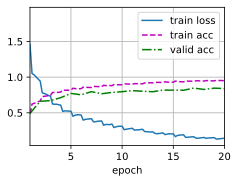

In [15]:
# 这里是用于调参
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 20, 2e-4, 5e-4
lr_period, lr_decay, net = 4, 0.9, get_net()
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

## 7 在 Kaggle 上对测试集进行分类并提交结果

在获得具有超参数的满意的模型后，我们使用所有标记的数据（包括验证集）来重新训练模型并对测试集进行分类。

train loss 0.128, train acc 0.956
252.3 examples/sec on [device(type='cuda', index=0)]


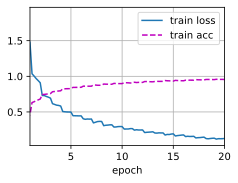

In [17]:
net, preds = get_net(), []
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

# Add net.eval() before testing
net.eval()
for X, _ in test_iter:
    y_hat = net(X.to(devices[0]))
    # y_hat里面值最高的那个下标取出来
    preds.extend(y_hat.argmax(dim=1).type(torch.int32).cpu().numpy())
sorted_ids = list(range(1, len(test_ds) + 1))
# 按字典序排序 例如 1-10 排序后为 1 10 2 3 4.....
sorted_ids.sort(key=lambda x: str(x))
df = pd.DataFrame({'id': sorted_ids, 'label': preds})
df['label'] = df['label'].apply(lambda x: train_valid_ds.classes[x])
df.to_csv('submission.csv', index=False)